# Train model CNN to recognize generated and original voice of different person **Combined Dataset Mixing Augmented**  

In [21]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [22]:
import sys
sys.path.append('../')

In [23]:
import librosa

from src.columns.combined_dataset_column import CombinedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
                    ToMelSpectrogramTransform(
                        sample_rate=sample_rate, n_mels=64, n_fft=512)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

In [24]:
SAMPLE_RATE = 16000
DATASET_PATH = '../dataset/'
DATA_PATH = '../data/'
MODEL_SAVE_PATH = '../model_save/'
BATCH_SIZE = 24

In [25]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation
SAMPLE_RATE = 16000
train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

In [26]:
train_df = pd.read_csv(DATASET_PATH + "train_combined_dataset.csv")
train_ds = CombinedSoundDS(train_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=train_transform)

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

In [27]:
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				self.conv_layers = nn.Sequential(
						nn.Conv2d(1, 32, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(32, 64, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(64, 128, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(128, 256, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
				)
				self.fc_layers = nn.Sequential(
						nn.Linear(4608, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [28]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [29]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred) for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)

	return avg_loss, accuracy, precision, recall, f1

In [30]:
def train_siamese_model(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	predictions = []
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		
		optimizer.zero_grad()
		output = model(anchor_sgram, posneg_sgram)
		loss = criterion(output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		predictions += [torch.argmax(pred) for pred in output.cpu()]
		true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)
	avg_loss = total_loss / len(dataloader)
	
	return avg_loss, accuracy, precision, recall, f1

In [31]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, output, label):
        label = label.long()
        loss = F.cross_entropy(output, label)
        return loss

In [32]:
num_epochs = 10
siamese_model = SiameseNetwork().to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])

Epoch 1/10, Loss: 0.6271, Accuracy: 0.6409, Precision: 0.6405, Recall: 0.6421, F1: 0.6413


Epoch 1/10, Loss: 0.5293, Accuracy: 0.7521, Precision: 0.7755, Recall: 0.7095, F1: 0.7411


Epoch 2/10, Loss: 0.5167, Accuracy: 0.7531, Precision: 0.7443, Recall: 0.7712, F1: 0.7575


Epoch 2/10, Loss: 0.5111, Accuracy: 0.7707, Precision: 0.6998, Recall: 0.9481, F1: 0.8053


Epoch 3/10, Loss: 0.4395, Accuracy: 0.7981, Precision: 0.7841, Recall: 0.8227, F1: 0.8029


Epoch 3/10, Loss: 0.3986, Accuracy: 0.8361, Precision: 0.7903, Recall: 0.9149, F1: 0.8481


Epoch 4/10, Loss: 0.3964, Accuracy: 0.8336, Precision: 0.8159, Recall: 0.8617, F1: 0.8382


Epoch 4/10, Loss: 0.4172, Accuracy: 0.8071, Precision: 0.7643, Recall: 0.8880, F1: 0.8215


Epoch 5/10, Loss: 0.3693, Accuracy: 0.8451, Precision: 0.8262, Recall: 0.8741, F1: 0.8495


Epoch 5/10, Loss: 0.3645, Accuracy: 0.8340, Precision: 0.7855, Recall: 0.9191, F1: 0.8470


Epoch 6/10, Loss: 0.3488, Accuracy: 0.8477, Precision: 0.8275, Recall: 0.8784, F1: 0.8522


Epoch 6/10, Loss: 0.3796, Accuracy: 0.8351, Precision: 0.7705, Recall: 0.9544, F1: 0.8526


Epoch 7/10, Loss: 0.3235, Accuracy: 0.8643, Precision: 0.8422, Recall: 0.8967, F1: 0.8686


Epoch 7/10, Loss: 0.3600, Accuracy: 0.8423, Precision: 0.8185, Recall: 0.8797, F1: 0.8480


Epoch 8/10, Loss: 0.3098, Accuracy: 0.8691, Precision: 0.8476, Recall: 0.9001, F1: 0.8730


Epoch 8/10, Loss: 0.4086, Accuracy: 0.8268, Precision: 0.7621, Recall: 0.9502, F1: 0.8458


Epoch 9/10, Loss: 0.2935, Accuracy: 0.8801, Precision: 0.8584, Recall: 0.9104, F1: 0.8837


Epoch 9/10, Loss: 0.4285, Accuracy: 0.8205, Precision: 0.7496, Recall: 0.9627, F1: 0.8429


Epoch 10/10, Loss: 0.2918, Accuracy: 0.8794, Precision: 0.8585, Recall: 0.9085, F1: 0.8828


Epoch 10/10, Loss: 0.3801, Accuracy: 0.8454, Precision: 0.7827, Recall: 0.9564, F1: 0.8609


In [34]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")
	plt.tight_layout()
	plt.show()

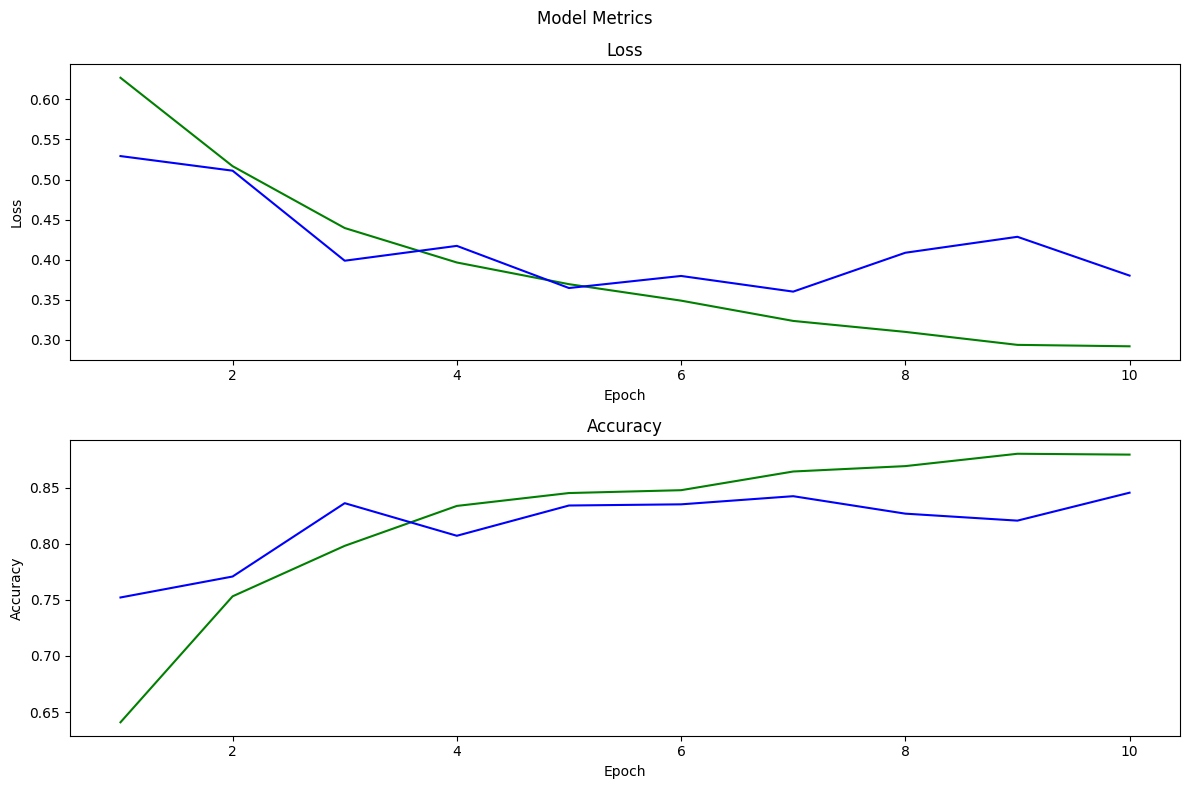

In [35]:
plot_metrix(loss, accuracy)

In [36]:
def save_model(model, model_name, base_path = './model_save/'):
  model.cpu()
  model.eval()
  torch.save(model, base_path + model_name)

In [37]:
save_model(siamese_model, "combined_cnn.pt")

RuntimeError: Parent directory ./model_save does not exist.

In [38]:
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	model.zero_grad()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad[0]), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad[0]), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad

In [39]:
def plot_explain_siamese_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad, lable):

    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.title("Anchor Sgram")
    plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
    plt.subplot(1, 2, 2)
    plt.title("Anchor Sgram Grad")
    text = "Positive" if lable.item() == 1 else "Negative"
    plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
               origin="lower", aspect="auto")
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.title(f"{text} Sgram")
    plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
    plt.subplot(1, 2, 2)
    plt.title(f"{text} Sgram Grad")
    plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
               origin="lower", aspect="auto")
    plt.show()

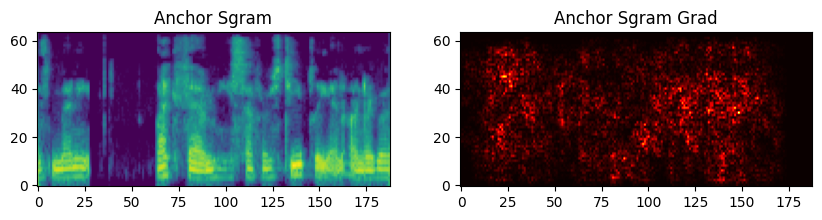

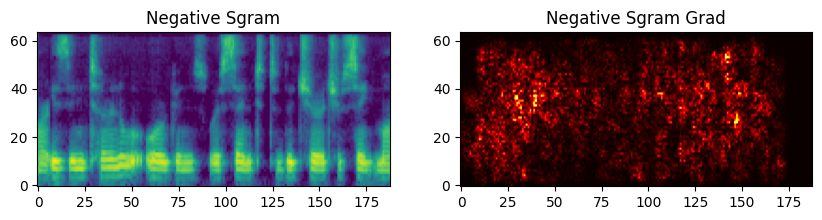

In [40]:
anchor_sgram, posneg_sgram, lable = test_ds[15]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad, lable)

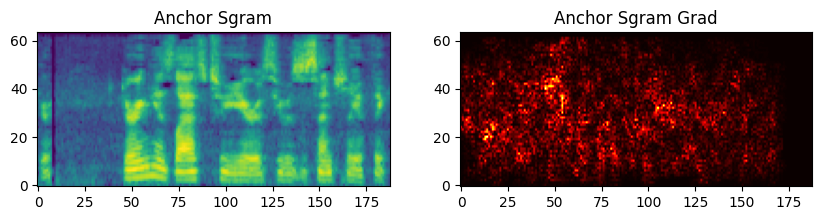

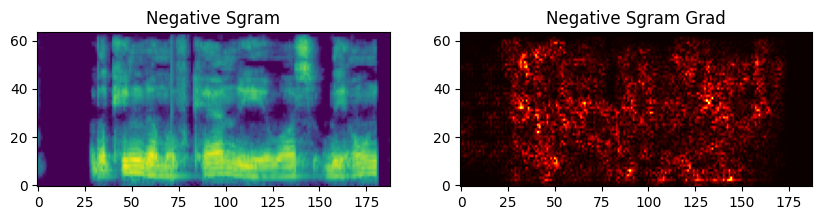

In [41]:


anchor_sgram, posneg_sgram, label = train_ds[33]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad, label)

In [42]:
def test(model, dataloader, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions

In [43]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels =  [ "Negative","Positive"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()

In [44]:
from src.dataset.base_dataset import BaseSoundDS


test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.7489626556016598


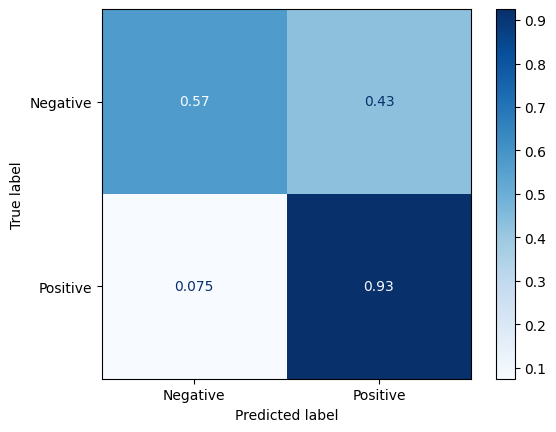

In [45]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [46]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset.csv")
test_ds = GeneratedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.8971014492753623


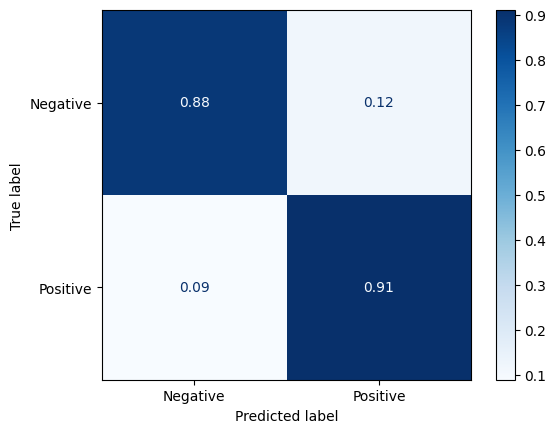

In [47]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [48]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset.csv")
test_ds = GeneratedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_your_tts/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.9507246376811594


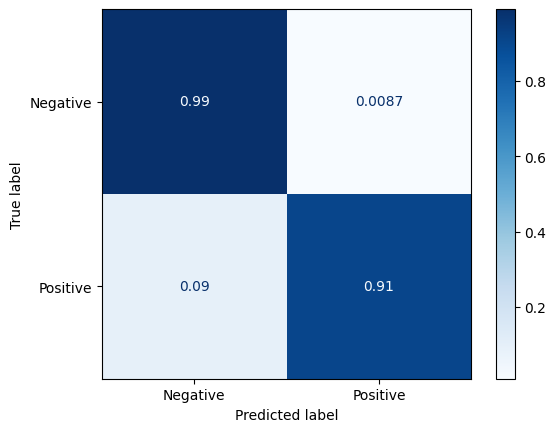

In [49]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [50]:
from src.dataset.combined_dataset import CombinedSoundDS


test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


accuracy: 0.8195020746887967


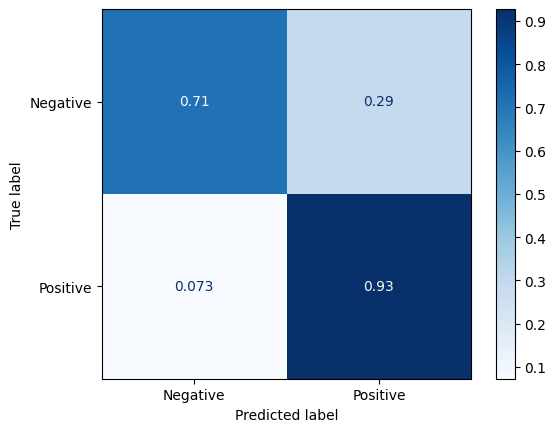

In [51]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [52]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation
SAMPLE_RATE=16000
test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)
test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform = test_transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.7987551867219918


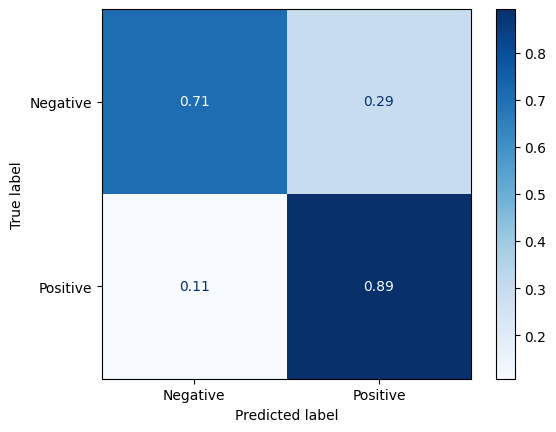

In [53]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)